In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


# Distance Ladder Numerical and Data Exercises

## 2. Distances using RR Lyrae standard candles

*Author: Dave Mykytyn*

The [Clementini et al. 2018](https://ui.adsabs.harvard.edu/#abs/2018arXiv180502079C/abstract) RR Lyrae results are available from the Gaia data set, which we can access through the astroquery Python package.

In [2]:
tables = Gaia.load_tables()

Retrieving tables...
Parsing tables...
Done.


First, let's construst our query. We use the prebuilt rr_lyrae table in Gaia DR2, and get all of the parameters of interest. We will retrieve stars within a small radius around both M62 and Sculptor, so we build those parameters into the query string.

In [3]:
querystart = r"SELECT "

rr_params = ["source_id", "pf", "pf_error", "int_average_g", 
             "int_average_g_error", "int_average_bp", "int_average_bp_error",
             "int_average_rp", "int_average_rp_error", "metallicity", "metallicity_error",
             "g_absorption", "best_classification", "peak_to_peak_g"]
gs_params = ["ra", "ra_error", "dec", "dec_error", "parallax", "parallax_error"]
rs_prefix = ', '.join(["rr.{}".format(rr_param) for rr_param in rr_params])
gs_prefix = ', '.join(["gs.{}".format(gs_param) for gs_param in gs_params])
querymid = r" FROM gaiadr2.vari_rrlyrae AS rr JOIN gaiadr2.gaia_source AS gs "
queryobjloc = r"ON gs.source_id=rr.source_id WHERE 1=INTERSECTS (POINT ('ICRS', gs.RA, gs.DEC), "
queryend = "CIRCLE('ICRS',{ra}, {dec}, {radius}))"

The complete query will then have the following form.

In [4]:
completequery = querystart + rs_prefix +', ' + gs_prefix + \
    querymid + queryobjloc + queryend

print(completequery)


SELECT rr.source_id, rr.pf, rr.pf_error, rr.int_average_g, rr.int_average_g_error, rr.int_average_bp, rr.int_average_bp_error, rr.int_average_rp, rr.int_average_rp_error, rr.metallicity, rr.metallicity_error, rr.g_absorption, rr.best_classification, rr.peak_to_peak_g, gs.ra, gs.ra_error, gs.dec, gs.dec_error, gs.parallax, gs.parallax_error FROM gaiadr2.vari_rrlyrae AS rr JOIN gaiadr2.gaia_source AS gs ON gs.source_id=rr.source_id WHERE 1=INTERSECTS (POINT ('ICRS', gs.RA, gs.DEC), CIRCLE('ICRS',{ra}, {dec}, {radius}))


astropy's SkyCoord can resolve names to RA and Dec for convenience. This uses the CDS name resolver service.

In [5]:
m62_coords = SkyCoord.from_name('m62')
sdg_coords = SkyCoord.from_name('Sculptor Dwarf Galaxy')
print(m62_coords)
print(sdg_coords)

<SkyCoord (ICRS): (ra, dec) in deg
    (255.3025, -30.112361)>
<SkyCoord (ICRS): (ra, dec) in deg
    (15.03917, -33.70889)>


Then we can retrieve from the Gaia databases stars within 15 arcminutes of each object.

In [6]:
querysdg = completequery.format(ra=sdg_coords.ra.deg, dec=sdg_coords.dec.deg, radius=0.25)
jobsdg = Gaia.launch_job(query=querysdg)
querym62 = completequery.format(ra=m62_coords.ra.deg, dec=m62_coords.dec.deg, radius=0.25)
jobm62 = Gaia.launch_job(query=querym62)

Here, we do a few basic cuts, to remove objects in which the period or metallicity have not been measured, and a few (presumed) outliers in M62, perhaps due to RR Lyrae along the line of sight or other errors. 

In [7]:
sdg = jobsdg.get_results() # this returns an astropy Table
sdg = sdg[~sdg['pf'].mask]
sdg = sdg[~sdg['metallicity'].mask]

m62 = jobm62.get_results() # this returns an astropy Table
m62 = m62[~m62['pf'].mask]
m62 = m62[~m62['metallicity'].mask]
m62 = m62[15.<m62['int_average_g']]
m62 = m62[m62['int_average_g'] < 17.]

Just as a sanity check, let us look at the RA and Dec distribution in each case

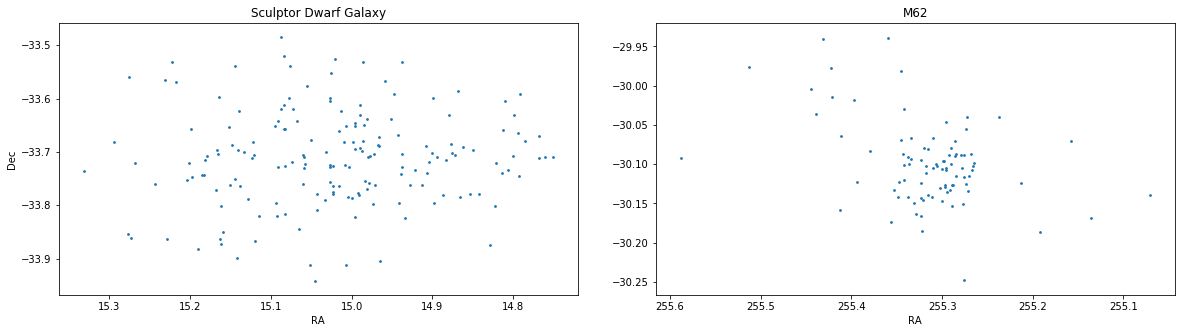

In [8]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.scatter(sdg['ra'], sdg['dec'], s=3)
plt.gca().invert_xaxis()
plt.xlabel("RA")
plt.ylabel("Dec")
plt.title('Sculptor Dwarf Galaxy')
plt.subplot(1, 2, 2)
plt.scatter(m62['ra'], m62['dec'], s=3)
plt.gca().invert_xaxis()
plt.xlabel("RA")
plt.title('M62')
plt.subplots_adjust(wspace=.15)
plt.show()

Now plot the period-luminosity relation. Already we can see potential problems, since the Sculptor Dwarf Galaxy RR Lyrae are clearly near Gaia's detection limit so may be affected by bias, perhaps as a function of luminosity. Although the RR Lyrae period-luminosity relation is supposed to be weak in the G band, for Sculptor it appears strong. Meanwhile, for M62 there appears to be more scatter than the typical 0.1 mag usually quoted for RR Lyrae. 

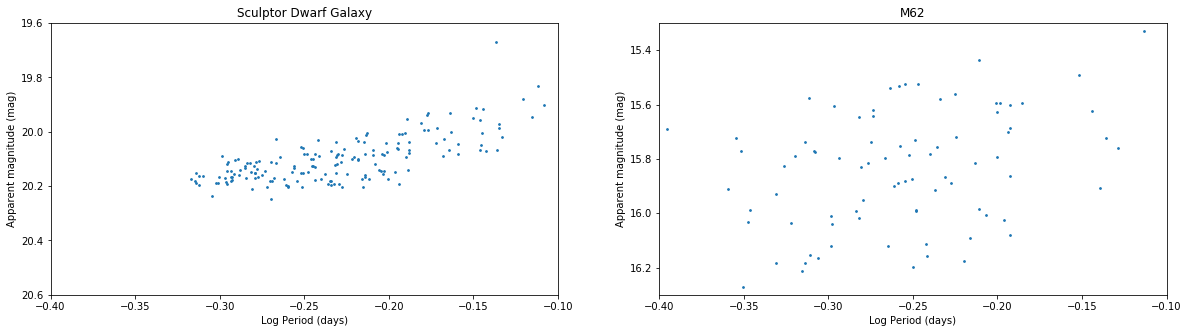

In [9]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.scatter(np.log10(sdg['pf']), sdg['int_average_g'], s=3)
plt.gca().invert_yaxis()
plt.xlabel('Log Period (days)')
plt.ylabel('Apparent magnitude (mag)')
plt.xlim([-0.4, -0.1])
plt.ylim([20.6, 19.6])
plt.title('Sculptor Dwarf Galaxy')
plt.subplot(1, 2, 2)
plt.scatter(np.log10(m62['pf']), m62['int_average_g'], s=3)
plt.gca().invert_yaxis()
plt.xlabel('Log Period (days)')
plt.ylabel('Apparent magnitude (mag)')
plt.xlim([-0.4, -0.1])
plt.ylim([16.3, 15.3])
plt.title('M62')
plt.show()

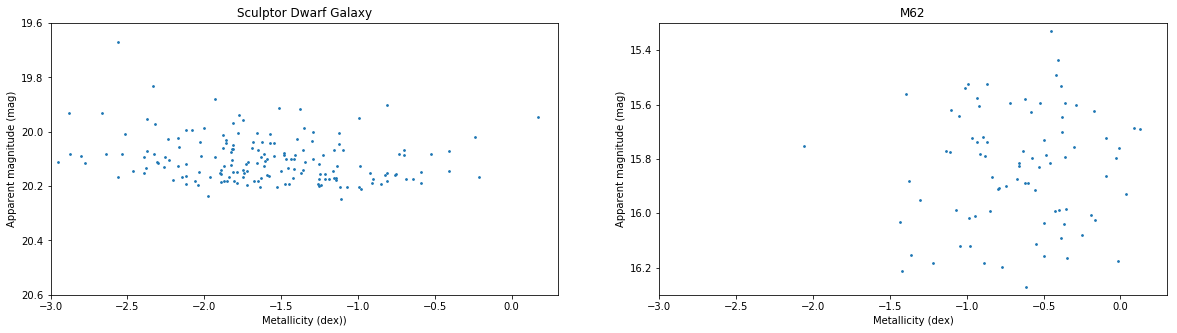

In [10]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.scatter(sdg['metallicity'], sdg['int_average_g'], s=3)
plt.gca().invert_yaxis()
plt.xlabel('Metallicity (dex))')
plt.ylabel('Apparent magnitude (mag)')
plt.xlim([-3.0, 0.3])
plt.ylim([20.6, 19.6])
plt.title('Sculptor Dwarf Galaxy')
plt.subplot(1, 2, 2)
plt.scatter(m62['metallicity'], m62['int_average_g'], s=3)
plt.gca().invert_yaxis()
plt.xlabel('Metallicity (dex)')
plt.ylabel('Apparent magnitude (mag)')
plt.xlim([-3.0, 0.3])
plt.ylim([16.3, 15.3])
plt.title('M62')
plt.show()

Finally, we are just going to eyeball a good fit to each distribution using the relation between $M_G$ and metallicity found in [Muraveva et al. (2018)](https://ui.adsabs.harvard.edu/#abs/2018MNRAS.481.1195M/abstract), Table 4:

$$
M_G = 0.32 {\rm [Fe/ H]} + 1.11
$$

The plots below make a guess at the distance modulus for each object.
It appears as if Gaia is only seeing the brightest of the RR Lyrae in Sculptor, and this means we don't have a very good handle on its distance modulus. 

Note that in the case of M62 we have to account for the fact that it is in a dusty region of the Milky Way, with an estimated $A_V \sim 1.4$, which we apply to the $G$ band. There is the possibility that M62 is not behind all of this dust, which complicates matters, and we ignore this here.

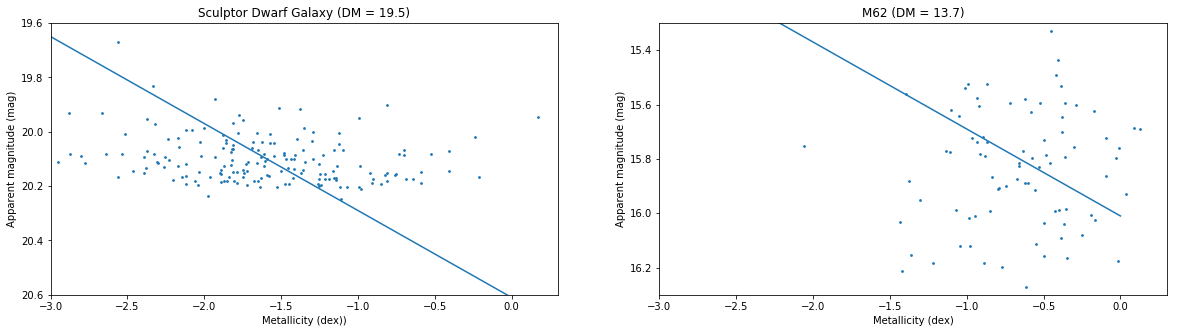

In [19]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.scatter(sdg['metallicity'], sdg['int_average_g'], s=3)
plt.gca().invert_yaxis()
plt.xlabel('Metallicity (dex))')
plt.ylabel('Apparent magnitude (mag)')
plt.xlim([-3.0, 0.3])
plt.ylim([20.6, 19.6])

sdg_dm = 19.5
xline = np.array([-3., 0.])
yline = xline * 0.32 + 1.11 + sdg_dm
plt.plot(xline, yline)
plt.title('Sculptor Dwarf Galaxy (DM = {dm})'.format(dm=sdg_dm))

plt.subplot(1, 2, 2)
plt.scatter(m62['metallicity'], m62['int_average_g'], s=3)
plt.gca().invert_yaxis()
plt.xlabel('Metallicity (dex)')
plt.ylabel('Apparent magnitude (mag)')
plt.xlim([-3.0, 0.3])
plt.ylim([16.3, 15.3])

m62_dm = 13.7
xline = np.array([-3., 0.])
yline = xline * 0.32 + 1.11 + m62_dm + 1.2
plt.plot(xline, yline)
plt.title('M62 (DM = {dm})'.format(dm=m62_dm))

plt.show()

Nevertheless, if we take these distance moduli seriously then the relative distances are:

In [20]:
print(10.**(0.2 * (sdg_dm - m62_dm)))

14.45439770745928


The individual distances in pc can also be inferred:

In [21]:
print(10. * 10.**(0.2 * sdg_dm))

79432.82347242822


In [22]:
print(10. * 10.**(0.2 * m62_dm))

5495.408738576248


These can be compared to the literature distances of 90 kpc for Sculptor and 7 kpc for M62. Our RR Lyrae based distances are in the ballpark but not very precisely so, perhaps due to the flux limit in the case of Sculptor and the dust in the case of M62. 